<a href="https://colab.research.google.com/github/kriangkraitan/Learining_Notebook/blob/main/Notebook_TimeSeries_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TimeSeries Data
### by [Kraitan B.](https://www.linkedin.com/in/kriangkrai-tan/)

เอาไว้ให้ตัวเองเรียน มีอะไรใหม่ ๆ จะพยายามมาอัพเดทเรื่อย ๆ 🤗

### Install

In [1]:
! pip install kaggle

### Data

ขอบคุณ data ตัวอย่างจากทางโครงการ SuperAI Season 3 [Stock Investment Prediction](https://www.kaggle.com/competitions/stock-investment-prediction)
😎
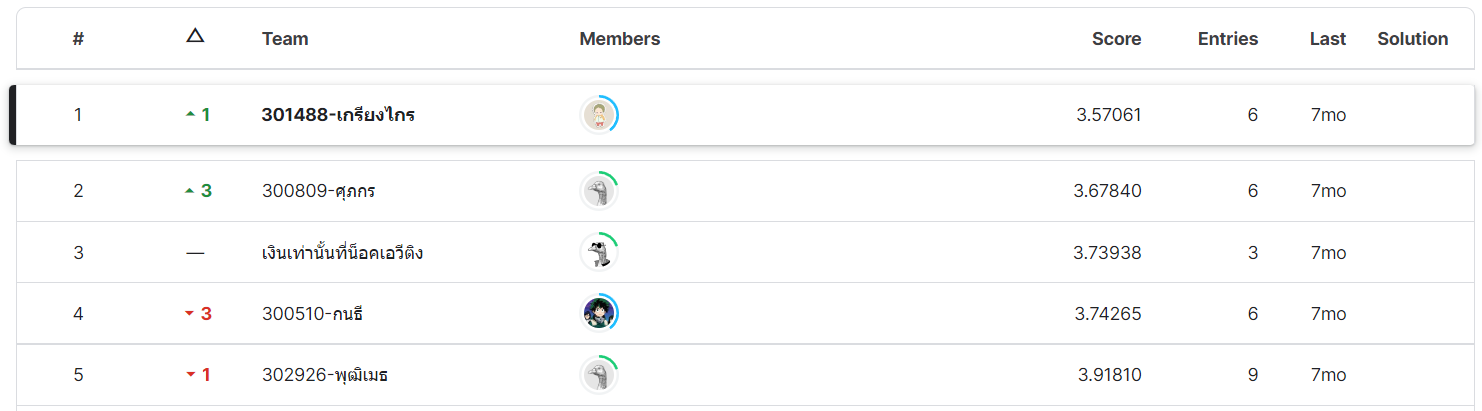

In [3]:
# download kaggle data in Google Colab
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c stock-investment-prediction

mkdir: cannot create directory ‘/root/.kaggle’: File exists
  0% 0.00/12.5k [00:00<?, ?B/s]
100% 12.5k/12.5k [00:00<00:00, 24.8MB/s]


In [4]:
! unzip /content/stock-investment-prediction.zip

Archive:  /content/stock-investment-prediction.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


## Time series with Autogluon

In [6]:
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

### Data Preparation

In [ ]:
! pip install autogluon.timeseries

In [12]:
df = pd.read_csv("/content/train.csv")
df.head()

,id,price
0,1,0.455
1,2,0.465
2,3,0.450
3,4,0.445
4,5,0.440


In [13]:
import pandas as pd
from datetime import datetime, timedelta

# Define start date and number of days
start_date = datetime(2009, 1, 1)
num_days = 3200

# Create a list of dates using pandas date_range function
date_range = pd.date_range(start=start_date, periods=num_days, freq='D')
df['date'] = pd.DataFrame({'Date': date_range})
df['item'] = pd.DataFrame(['Stock']*df.shape[0])
df = df.drop(columns='id')
df.head()

,price,date,item
0,0.455,2009-01-01,Stock
1,0.465,2009-01-02,Stock
2,0.450,2009-01-03,Stock
3,0.445,2009-01-04,Stock
4,0.440,2009-01-05,Stock


AutoGluon expects time series data in [long format](https://doc.dataiku.com/dss/latest/time-series/data-formatting.html#long-format).
Each row of the data frame contains a single observation (timestep) of a single time series represented by

- unique ID of the time series (`"item"`) as int or str
- timestamp of the observation (`"date"`) as a `pandas.Timestamp` or compatible format
- numeric value of the time series (`"price"`)

The raw dataset should always follow this format with at least three columns for unique ID, timestamp, and target value, but the names of these columns can be arbitrary.
It is important, however, that we provide the names of the columns when constructing a `TimeSeriesDataFrame` that is used by AutoGluon.
AutoGluon will raise an exception if the data doesn't match the expected format.

In [14]:
train_data = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="item",
    timestamp_column="date"
)
train_data.head()


price
item_id timestamp        
Stock   2009-01-01  0.455
        2009-01-02  0.465
        2009-01-03  0.450
        2009-01-04  0.445
        2009-01-05  0.440

In [16]:
# setting frequency
train_data = train_data.convert_frequency(freq="D")

### Training time series models with **TimeSeriesPredictor.fit**

We refer to each individual time series stored in a `TimeSeriesDataFrame` as an _item_.
For example, items might correspond to different products in demand forecasting, or to different stocks in financial datasets.
This setting is also referred to as a _panel_ of time series.
Note that this is *not* the same as multivariate forecasting — AutoGluon generates forecasts for each time series individually, without modeling interactions between different items (time series).

`TimeSeriesDataFrame` inherits from [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html), so all attributes and methods of `pandas.DataFrame` are available in a `TimeSeriesDataFrame`.
It also provides other utility functions, such as loaders for different data formats (see [TimeSeriesDataFrame](../../api/autogluon.timeseries.TimeSeriesDataFrame) for details).

## Training time series models with `TimeSeriesPredictor.fit`
To forecast future values of the time series, we need to create a `TimeSeriesPredictor` object.

Models in `autogluon.timeseries` forecast time series _multiple steps_ into the future.
We choose the number of these steps — the _prediction length_ (also known as the _forecast horizon_) —  depending on our task.
For example, our dataset contains time series measured at daily _frequency_, so we set `prediction_length = 300` to train models that forecast up to 300 days into the future.

We instruct AutoGluon to save trained models in the folder `./autogluon-m4-hourly`.
We also specify that AutoGluon should rank models according to [mean absolute scaled error (MASE)](https://en.wikipedia.org/wiki/Mean_absolute_scaled_error), and that data that we want to forecast is stored in the column `"price"` of the `TimeSeriesDataFrame`.

presets >>> [Autogluon TimeSeries Preset](https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-indepth.html#basic-configuration-with-presets-and-time-limit)

In [ ]:
import autogluon.core as ag
predictor = TimeSeriesPredictor(
    prediction_length=300,
    path="model",
    target="price",
    eval_metric="MASE"
)

predictor.fit(
    train_data,
    presets = "medium_quality"
)


Generating forecasts with TimeSeriesPredictor.predict

In [ ]:
predictions = predictor.predict(train_data)
predictions.head()